This notebook tests the mock (ELG) galaxy catalogues generated from AbacusSummit

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import glob
import os
import matplotlib.pyplot as plt

Read in file 

# Check one redshift bin

In [2]:
# hod model number
model_no = 6

z_in = 0.576#0.576

# HOD directory on gosling1
hod_dir = "/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/z%.3f/model_%d/"%(z_in,model_no)

sats_fns = sorted(glob.glob(hod_dir+"*sats*"))
cent_fns = sorted(glob.glob(hod_dir+"*cent*"))

print(len(cent_fns),len(sats_fns))

def load_gals(fns,dim):

    for fn in fns:
        tmp_arr = np.fromfile(fn).reshape(-1,dim)
        try:
            gal_arr = np.vstack((gal_arr,tmp_arr))
        except:
            gal_arr = tmp_arr
            
    return gal_arr

sats_arr = load_gals(sats_fns,dim=9)
cent_arr = load_gals(cent_fns,dim=9)

# first three columns of file are positions, next are velocities, then halo index and finally halo mass
sats_pos = sats_arr[:,0:3]
cent_pos = cent_arr[:,0:3]
sats_mass = sats_arr[:,-1]
cent_mass = cent_arr[:,-1]

print(sats_pos.shape)
print(cent_pos.shape)

print(f'central pos min {cent_pos.min()}')
print(f'central pos max {cent_pos.max()}')
print(f'sat pos min {sats_pos.min()}')
print(f'sat pos max {sats_pos.max()}')

x_min = 0
x_max = x_min+80.
i = 1
j = 2
k = 0
sel_cent = (cent_pos[:,k] > x_min) & (cent_pos[:,k] < x_max)
sel_sats = (sats_pos[:,k] > x_min) & (sats_pos[:,k] < x_max)

print("number of centrals in cross section = ",np.sum(sel_cent))
print("number of satellites in cross section = ",np.sum(sel_sats))

1 1
(302404, 3)
(524230, 3)
central pos min -0.219970703125
central pos max 1572.811279296875
sat pos min -0.00201416015625
sat pos max 1573.1920166015625
number of centrals in cross section =  28815
number of satellites in cross section =  17128


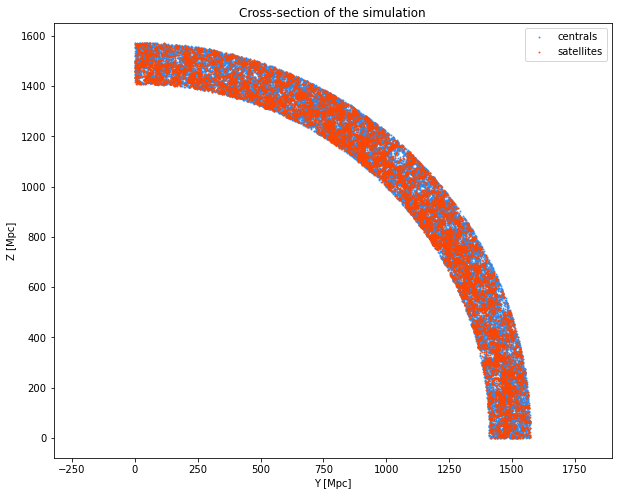

In [3]:
plt.figure(figsize=(10,8))
plt.title("Cross-section of the simulation")
plt.scatter(cent_pos[sel_cent,i],cent_pos[sel_cent,j],color='dodgerblue',s=1,alpha=0.8,label='centrals')
plt.scatter(sats_pos[sel_sats,i],sats_pos[sel_sats,j],color='orangered',s=1,alpha=0.8,label='satellites')
plt.axis('equal')
plt.xlabel('Y [Mpc]')
plt.ylabel('Z [Mpc]')
plt.legend(loc = 'best')
plt.show()

# Calculate dn using `blanc` n(z) model and AbacusSummit effective area

Import n(z) model

In [5]:
home='/mnt/store1/tkarim/cmb_lensing/data/'
fname='nz_blanc.txt'
nz = pd.read_csv(home + fname)

#clip range to 0.45 <= z <= 1.7
zrange_low = 0.45; zrange_high = 1.41

def flag(array, zrange_low = zrange_low, zrange_high = zrange_high):
    """Returns flags to clip data array into desired redshift range"""
    
    return (array >= zrange_low) & (array <= zrange_high)

#select objects in redshift range
nz = nz[flag(nz['Redshift_mid'])]
zmid = nz['Redshift_mid']
dndzddeg2 = nz['dndz/deg^2']

Import area(z) model which tells us what is the effective sky area coverage as a function of redshift

In [6]:
dirname = '/mnt/gosling1/boryanah/light_cone_catalog/sky_coverage/'
zs_mt = np.load(dirname + "zs_mt.npy")
fs_sky = np.load(dirname + "fs_sky.npy")

#clip the file to be in the redshift range; order matters since we are using zs_mt
fs_sky = fs_sky[flag(zs_mt)]
zs_mt = zs_mt[flag(zs_mt)]

Text(0, 0.5, 'deg$^2$')

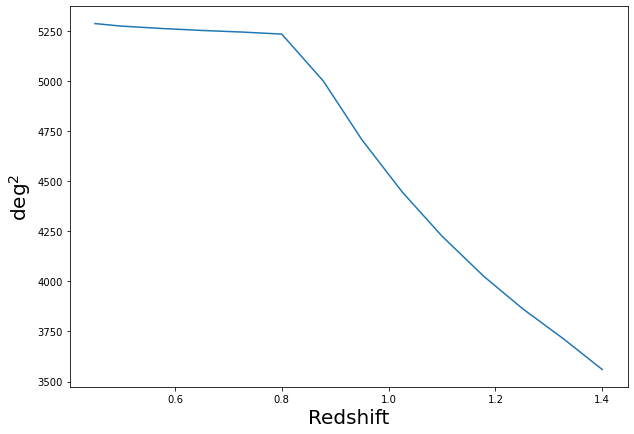

In [7]:
fs = 20; fsize = (10, 7)
plt.figure(figsize = fsize)
plt.plot(zs_mt, fs_sky)
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel(r"deg$^2$", fontsize = fs)

In [8]:
#calculate the number of objects per redshift bin 
abacus_area = fs_sky
dn = dndzddeg2 * nz['Bin_width'] * abacus_area

In [9]:
#add abacus area for dndz use in CCL
#nz['abacus_area'] = fs_sky
#nz.to_csv("nz_blanc+abacus.txt")

In [10]:
def nz_plotter(z, count, xlabel, ylabel, figsize = (10, 7), fs = 20):
    """generates nz plots based on redshift and counts"""
    plt.figure(figsize=figsize)
    plt.plot(z, count)
    plt.xlabel(xlabel, fontsize = fs)
    plt.ylabel(ylabel, fontsize = fs) 

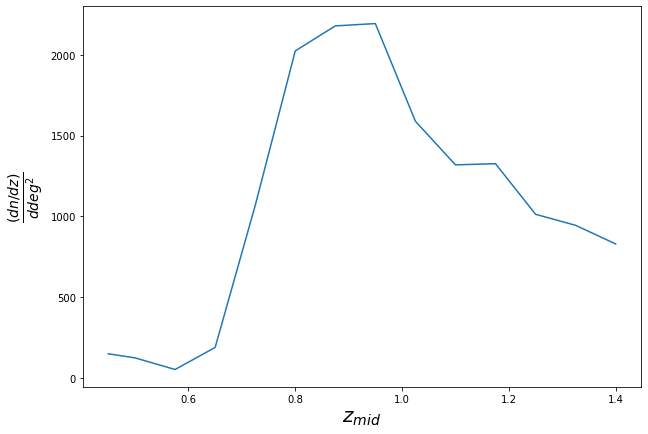

In [11]:
nz_plotter(zmid, dndzddeg2, r"$z_{mid}$", r"$\frac{(dn/dz)}{ddeg^2}$")

Convert `dndzddeg2` to `dn` to get the number of objects in a given redshift bin

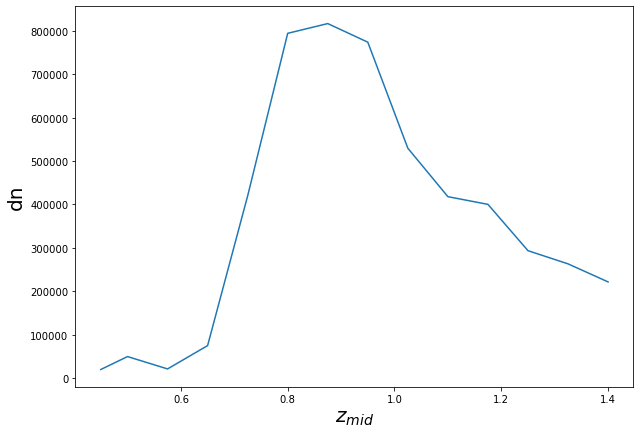

In [12]:
nz_plotter(zmid, dn, r"$z_{mid}$", "dn")

In [13]:
print(f'Total number of galaxies EXPECTED in this simulation in the redshift range {zrange_low} <= z <= {zrange_high}: {np.sum(dn)}')

Total number of galaxies EXPECTED in this simulation in the redshift range 0.45 <= z <= 1.41: 5096400.087795739


In [14]:
#Check if the total expected number of ELGs based on this dndzddeg2 yields DESI
np.sum(dndzddeg2 * nz['Bin_width'] * 14000)

15648397.557380501

Determine `zmid` for the light cone catalogues

In [16]:
hod_files = !ls /mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/
zmid_abacus = [np.float(redz[1:]) for redz in hod_files]
zmid_abacus = np.array(zmid_abacus)

Count the number of ELGs per redshift bin in AbacusSummit based on HOD

In [30]:
def gal_count_abacus(model_no, z_in, rsd = False, datadir = '/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD'):
    """Outputs the number of ELGs per Abacus redshift bin
    
    Inputs
        model_no : HOD model number
        z_in : redshift bin
        rsd : If RSD model is needed; default False for angular clustering
        
    Outputs
        galaxy_tot : Total number of ELGs in redshift bin z_in based on HOD model_no
    """
    
    # HOD directory on gosling1
    if(rsd):
        hod_dir = datadir + "/z%.3f/model_%d_rsd/"%(z_in,model_no)
    else:
        hod_dir = datadir + "/z%.3f/model_%d/"%(z_in,model_no)
    
    sats_fns = sorted(glob.glob(hod_dir+"*sats*"))
    cent_fns = sorted(glob.glob(hod_dir+"*cent*"))
    
    def load_gals(fns,dim):

        for fn in fns:
            tmp_arr = np.fromfile(fn).reshape(-1,dim)
            try:
                gal_arr = np.vstack((gal_arr,tmp_arr))
            except:
                gal_arr = tmp_arr
                
        return gal_arr

    sats_arr = load_gals(sats_fns,dim=9)
    cent_arr = load_gals(cent_fns,dim=9)
    
    galaxy_tot = sats_arr.shape[0] + cent_arr.shape[0]
    
    return galaxy_tot

In [18]:
dn_abacus = []

for z in zmid_abacus:
    dn_abacus.append(gal_count_abacus(model_no=5, z_in = z))
    
dn_abacus = np.array(dn_abacus)

Text(0, 0.5, 'dN')

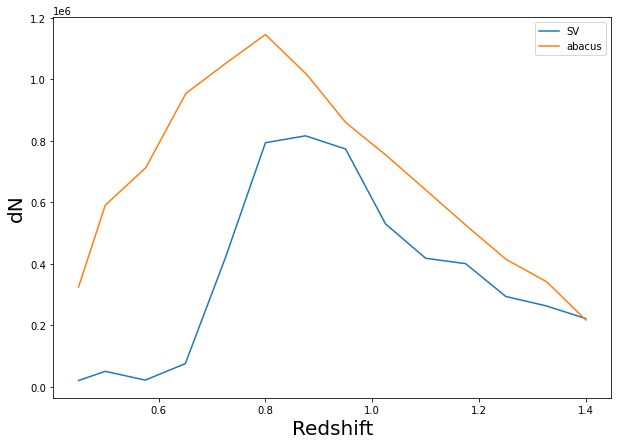

In [19]:
plt.figure(figsize = fsize)
plt.plot(zmid, dn, label = 'SV')
plt.plot(zmid_abacus, dn_abacus, label = 'abacus')
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("dN", fontsize = fs)

Text(0, 0.5, 'Downsampling factor')

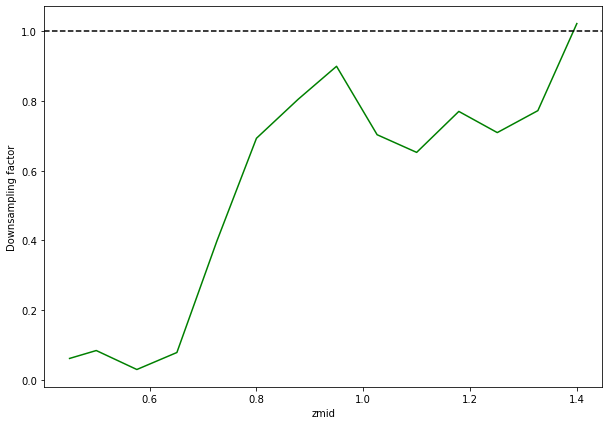

In [22]:
#calculate downsampling factor
downsample_factor = dn/dn_abacus

plt.figure(figsize = (10, 7))
plt.plot(zmid_abacus, downsample_factor, c = 'g')
plt.axhline(1, ls = "--", c = 'k')
plt.xlabel("zmid")
plt.ylabel("Downsampling factor")

Therefore, Abacus has a higher fraction of objects per redshift bin compared to `blanc`. 

In [23]:
downsample_factor

1     0.061544
2     0.084224
3     0.029833
4     0.078579
5     0.398621
6     0.692864
7     0.804555
8     0.899265
9     0.703032
10    0.652412
11    0.769866
12    0.709164
13    0.772088
14    1.021755
dtype: float64

# Downsample Abacus galaxies to match `blanc` n(z)

In [24]:
#run this cell to pass zmid_abacus to downsample()
hod_files = !ls /mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/
zmid_abacus = [np.float(redz[1:]) for redz in hod_files]
zmid_abacus = np.array(zmid_abacus)

In [26]:
def downsample(model_no, z_in, nz, zmid = zmid_abacus, rsd = False):
    """Downsamples Abacus HOD models to fit SV n(z) for a given redshift bin.
    redshift bins in z_in and nz must match.
    
    Inputs
        model_no : HOD model number
        z_in : redshift bin
        nz : n(z) array
        zmid : array of redshift bins, according to the bin midpoint
        rsd : If RSD model is needed; default False for angular clustering
        
    Outputs
        sats_arr_downsampled : downsampled satellite galaxies
        cent_arr_downsampled : downsampled central galaxies
    """
    
        # HOD directory on gosling1
    if(rsd):
        hod_dir = "/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/z%.3f/model_%d_rsd/"%(z_in,model_no)
    else:
        hod_dir = "/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/z%.3f/model_%d/"%(z_in,model_no)
    
    sats_fns = sorted(glob.glob(hod_dir+"*sats*"))
    cent_fns = sorted(glob.glob(hod_dir+"*cent*"))
    
    def load_gals(fns,dim):

        for fn in fns:
            tmp_arr = np.fromfile(fn).reshape(-1,dim)
            try:
                gal_arr = np.vstack((gal_arr,tmp_arr))
            except:
                gal_arr = tmp_arr
                
        return gal_arr

    sats_arr = load_gals(sats_fns,dim=9)
    cent_arr = load_gals(cent_fns,dim=9)
    
    #total number of galaxies in bin z_in
    dn_abacus_z_in = sats_arr.shape[0] + cent_arr.shape[0]
    
    #downsample Abacus galaxies to match nz profile
    downsample_factor = nz[zmid == z_in].values[0]/dn_abacus_z_in
    
    bool_cent = np.random.uniform(size = cent_arr.shape[0]) <= downsample_factor
    bool_sats = np.random.uniform(size = sats_arr.shape[0]) <= downsample_factor
    
    sats_arr_downsampled = sats_arr[bool_sats]
    cent_arr_downsampled = cent_arr[bool_cent]
    
    return sats_arr_downsampled, cent_arr_downsampled
    
    

Run `downsample()` over all redshifit bins

In [32]:
datadir = "/mnt/gosling1/tkarim/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/"

for z_in in zmid_abacus:
    #create directory to save files if does not exist
    fdir = datadir + 'z%.3f/model_%d/'%(z_in, model_no)
    if not os.path.exists(fdir):
        os.makedirs(fdir)
    
    #run downsample function
    sats_arr_downsampled, cent_arr_downsampled = downsample(model_no, z_in, dn)

    #save downsampled files
    np.save(fdir + 'sats_elg_downsampled', sats_arr_downsampled)
    np.save(fdir + 'cent_elg_downsampled', cent_arr_downsampled)

# Compare downsampled n(z) with `blanc`

In [35]:
dn_abacus_downsampled = []

for z_in in zmid_abacus:
    sats_arr = np.load(datadir + 'z%.3f/model_%d/sats_elg_downsampled.npy'%(z_in, model_no))
    cent_arr = np.load(datadir + 'z%.3f/model_%d/cent_elg_downsampled.npy'%(z_in, model_no))
    
    galaxy_tot = sats_arr.shape[0] + cent_arr.shape[0]
    dn_abacus_downsampled.append(galaxy_tot)
    
dn_abacus_downsampled = np.array(dn_abacus_downsampled)

Text(0, 0.5, 'dN')

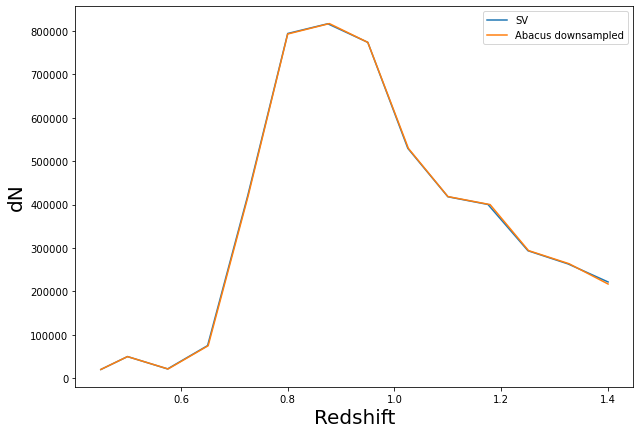

In [36]:
plt.figure(figsize = fsize)
plt.plot(zmid, dn, label = 'SV')
plt.plot(zmid_abacus, dn_abacus_downsampled, label = 'Abacus downsampled')
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("dN", fontsize = fs)

Text(0.5, 0, 'Redshift')

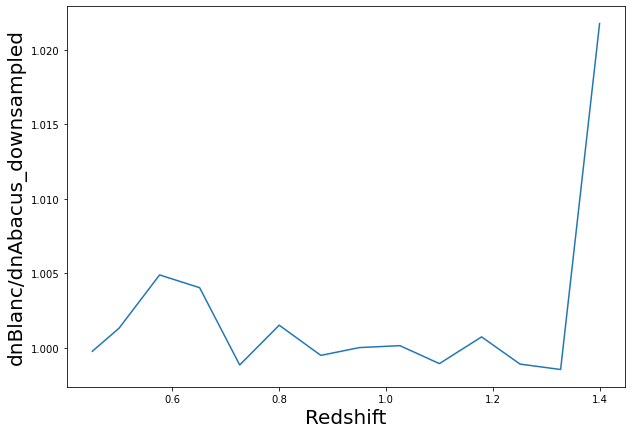

In [45]:
plt.figure(figsize = fsize)
plt.plot(zmid_abacus, dn/dn_abacus_downsampled)
plt.ylabel("dnBlanc/dnAbacus_downsampled", fontsize = fs)
plt.xlabel("Redshift", fontsize = fs)

In [38]:
# hod model number
model_no = 5

z_in = 0.576#0.576

# HOD directory on gosling1
hod_dir = "/mnt/gosling1/tkarim/light_cone_catalog/AbacusSummit_base_c000_ph006/HOD/z%.3f/model_%d/"%(z_in,model_no)

sats_fns = sorted(glob.glob(hod_dir+"*sats*"))
cent_fns = sorted(glob.glob(hod_dir+"*cent*"))

print(len(cent_fns),len(sats_fns))


sats_arr = np.load(sats_fns[0])
cent_arr = np.load(cent_fns[0])

# first three columns of file are positions, next are velocities, then halo index and finally halo mass
sats_pos = sats_arr[:,0:3]
cent_pos = cent_arr[:,0:3]
sats_mass = sats_arr[:,-1]
cent_mass = cent_arr[:,-1]

print(sats_pos.shape)
print(cent_pos.shape)

print(f'central pos min {cent_pos.min()}')
print(f'central pos max {cent_pos.max()}')
print(f'sat pos min {sats_pos.min()}')
print(f'sat pos max {sats_pos.max()}')

x_min = 0
x_max = x_min+80.
i = 1
j = 2
k = 0
sel_cent = (cent_pos[:,k] > x_min) & (cent_pos[:,k] < x_max)
sel_sats = (sats_pos[:,k] > x_min) & (sats_pos[:,k] < x_max)

1 1
(5353, 3)
(15815, 3)
central pos min 0.013427734375
central pos max 1572.15087890625
sat pos min 0.02197265625
sat pos max 1487.4859619140625


In [39]:
print("number of centrals in cross section = ",np.sum(sel_cent))
print("number of satellites in cross section = ",np.sum(sel_sats))

number of centrals in cross section =  909
number of satellites in cross section =  321


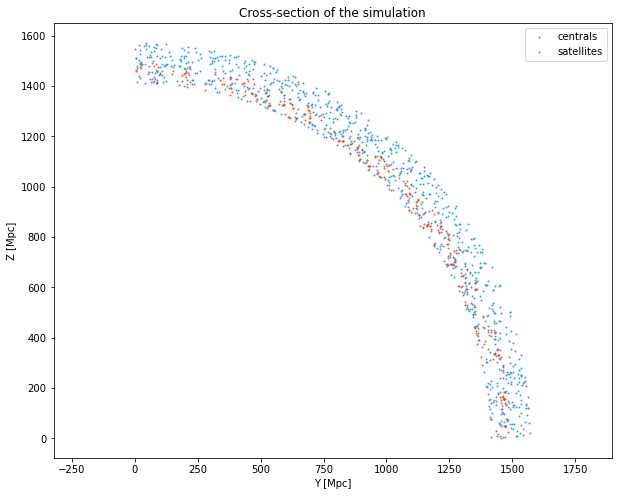

In [40]:
plt.figure(figsize=(10,8))
plt.title("Cross-section of the simulation")
plt.scatter(cent_pos[sel_cent,i],cent_pos[sel_cent,j],color='dodgerblue',s=1,alpha=0.8,label='centrals')
plt.scatter(sats_pos[sel_sats,i],sats_pos[sel_sats,j],color='orangered',s=1,alpha=0.8,label='satellites')
plt.axis('equal')
plt.xlabel('Y [Mpc]')
plt.ylabel('Z [Mpc]')
plt.legend(loc = 'best')
#plt.savefig("scatter.png")
plt.show()

In [41]:
dn[zmid_abacus == 0.576]

3    21271.282415
dtype: float64